# CS3 Processing Report

This example showcases the use of Paramaterial to process and analyse a set of uniaxial compression test data.

In [1]:
import paramaterial as pam
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from paramaterial import DataSet, DataItem
print('paramaterial', pam.__version__)
print('numpy', np.__version__)
print('matplotlib', mpl.__version__)

paramaterial 0.1.0
numpy 1.23.5
matplotlib 3.7.0


## Data preparation

In [2]:
pam.check_column_headers('data/01 raw data')
pam.check_for_duplicate_files('data/01 raw data')

Checking column headers...
First file headers:
	['Time(sec)', 'Force(kN)', 'Jaw(mm)', 'PowAngle(deg)', 'Power(W)', 'Pram', 'PTemp', 'Strain', 'Stress(MPa)', 'Stroke(mm)', 'TC1(C)', 'wedge(mm)']
Headers in all files are the same as in the first file, except for None.
Checking for duplicate files...
No duplicate files found in "data/01 raw data".


Load the data and info into a dataset object (ds is shorthand for dataset).

In [3]:
raw_ds = DataSet('info/01 raw info.xlsx', 'data/01 raw data').sort_by('temperature')

### Make the experimental matrix
We want to identify useful groupings and make visualisations.

The tests can be grouped by nominal rate, nominal temperature, and material. We will make the classic rate-temperature matrices - one for each material.

In [4]:
cmap_gold = mpl.colors.LinearSegmentedColormap.from_list("", ["white", (85/255, 49/255, 0)])
mpl.rcParams['axes.facecolor'] = cmap_gold(0.1)

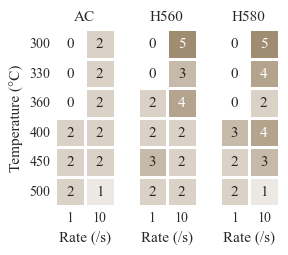

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(3, 2.3))
heatmap_kwargs = dict(linewidths=2, cbar=False, annot=True, cmap=cmap_gold, vmax=9)

pam.experimental_matrix(raw_ds.subset({'material': 'AC'}).info_table,
                             index='temperature', columns='rate', as_heatmap=True,
                             title='AC', xlabel='Rate (/s)', ylabel='Temperature (°C)',
                             tick_params=dict(rotation=0), ax=axs[0], **heatmap_kwargs)

pam.experimental_matrix(raw_ds.subset({'material': 'H560'}).info_table,
                             index='temperature', columns='rate', as_heatmap=True,
                             title='H560', xlabel='Rate (/s)', ylabel=' ',
                             tick_params=dict(labelleft=False), ax=axs[1], **heatmap_kwargs)

pam.experimental_matrix(raw_ds.subset({'material': 'H580'}).info_table,
                             index='temperature', columns='rate', as_heatmap=True,
                             title='H580', xlabel='Rate (/s)', ylabel=' ',
                             tick_params=dict(labelleft=False), ax=axs[2], **heatmap_kwargs);

### Setup data overview plot
Now that we know how to group the data, we can set up a plotting function.

In [6]:
styler = pam.plotting.Styler(color_by='temperature', color_by_label='(°C)', cmap='plasma').style_to(raw_ds)


def ds_subplot(ds: DataSet, **kwargs):
    return pam.plotting.dataset_subplots(
        ds, shape=(2, 3), xlim=(-0.2, 1.2), figsize=(8, 3.5),
        rows_by='rate', cols_by='material',
        row_vals=[[1], [10]], col_vals=[['AC'], ['H560'], ['H580']],
        col_titles=['AC', 'H560', 'H580'], row_titles=['1/s','10/s'],
        styler=styler, subplot_legend=False, plot_legend=False,
        **kwargs
    )


stress_strain_labels = dict(x='Strain', y='Stress(MPa)', xlabel='Strain (mm/mm)', ylabel='Stress (MPa)')

Plot the raw data.

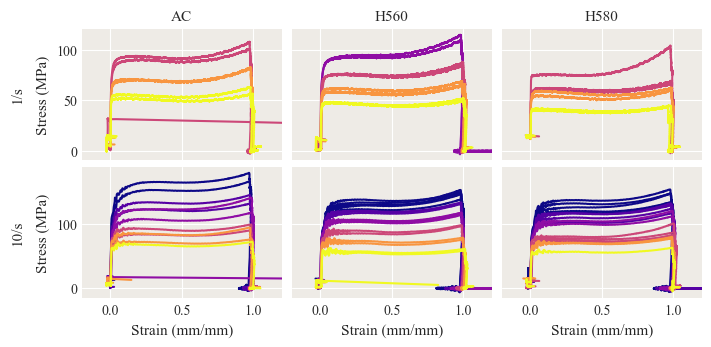

In [7]:
ds_subplot(raw_ds, **stress_strain_labels);

## Data processing

### Trim data

In [8]:
def drop_columns(di: DataItem) -> DataItem:
    di.data = di.data.drop(columns=['PowAngle(deg)', 'Power(W)', 'Pram', 'PTemp', 'Stroke(mm)', 'wedge(mm)'])
    return di


def trim_using_time_step(di: DataItem) -> DataItem:
    t_diff = np.diff(di.data['Time(sec)'])
    di.data['time diff'] = np.hstack([t_diff[0], t_diff])
    di.data = di.data[di.data['time diff'] < 0.02][1:]
    return di


def remove_trailing_data(di: DataItem):
    di.data = di.data.reset_index(drop=True)
    di.data = di.data.iloc[:di.data['Force(kN)'].idxmax()]
    return di

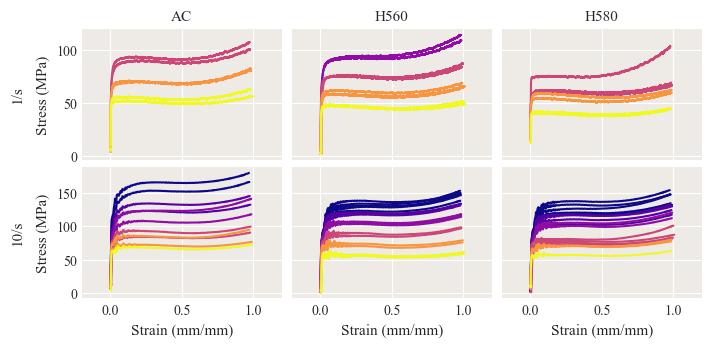

In [9]:
trimmed_ds = raw_ds.apply(drop_columns).apply(trim_using_time_step).apply(remove_trailing_data)
ds_subplot(trimmed_ds, **stress_strain_labels);

### Find flow stresses
Determine the stress, temperature for each test. Note that while nominal temperature is given, the actual test conditions are slightly different. The actual strain-rate does not differ significantly from the nominal rate for these tests.

In [10]:
rates_ds = pam.calculate_strain_rate(trimmed_ds, time_key='Time(sec)')
processed_ds = pam.find_flow_stress_values(rates_ds, flow_strain=0.3,
                                           stress_key='Stress(MPa)', temperature_key='TC1(C)', rate_key='Strain_Rate')

processed_ds.write_output('info/02 processed info.xlsx', 'data/02 processed data')

### Make representative curves

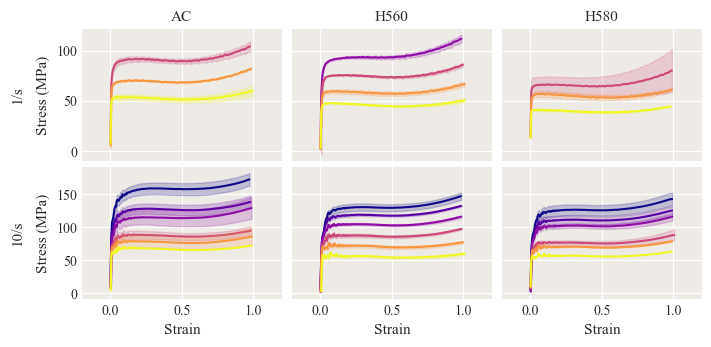

In [11]:
pam.make_representative_data(processed_ds, 'info/03 repr trim info.xlsx', 'data/03 repr trim data',
                             repres_col='Stress(MPa)', group_by_keys=['temperature', 'material', 'rate'],
                             interp_by='Strain', group_info_cols=['flow_Stress(MPa)'])
repr_ds = DataSet('info/03 repr trim info.xlsx', 'data/03 repr trim data', test_id_key='repres_id').sort_by('temperature')
ds_subplot(repr_ds, x='Strain', y='Stress(MPa)', xlabel='Strain', ylabel='Stress (MPa)',
           fill_between=('down_std_Stress(MPa)', 'up_std_Stress(MPa)'));

### Zener-Holloman Model

In [12]:
info_table = processed_ds.info_table
info_table['Q_activation'] = 155000.
info_table['flow_temp(K)'] = processed_ds.info_table['flow_TC1(C)'] + 273.15
processed_ds.info_table = info_table

In [13]:

analysis_ds = processed_ds.apply(pam.calculate_ZH_parameter, rate_key='flow_Strain_Rate',
                                 temperature_key='flow_temp(K)').sort_by(['material', 'rate'])

In [14]:
from matplotlib.colors import ListedColormap
cmap = mpl.colormaps['RdYlGn']
colors = cmap(np.arange(cmap.N))
colors[0] = (1, 1, 1, 1)
custom_cmap = ListedColormap(colors)


def conformance_matrix(_ds: DataSet, axs):
    heatmap_kwargs = dict(linewidths=4, cbar=False, annot=True, fmt='.1f', cmap=custom_cmap, vmin=80, vmax=100)
    pam.make_quality_matrix(_ds.subset({'material': 'AC'}).info_table, index='temperature', columns='rate',
                            flow_stress_key='flow_Stress(MPa)', as_heatmap=True, title='AC',
                            xlabel='Rate (/s)', ylabel='Temperature (°C)', tick_params=dict(rotation=0), ax=axs[0],
                            **heatmap_kwargs)
    pam.make_quality_matrix(_ds.subset({'material': 'H560'}).info_table, index='temperature', columns='rate',
                            flow_stress_key='flow_Stress(MPa)', as_heatmap=True, title='H560',
                            xlabel='Rate (/s)', ylabel=' ', tick_params=dict(labelleft=False), ax=axs[1],
                            **heatmap_kwargs)
    pam.make_quality_matrix(_ds.subset({'material': 'H580'}).info_table, index='temperature', columns='rate',
                            flow_stress_key='flow_Stress(MPa)', as_heatmap=True, title='H580',
                            xlabel='Rate (/s)', ylabel=' ', tick_params=dict(labelleft=False), ax=axs[2],
                            **heatmap_kwargs)
    return axs

In [15]:
material_analysis_ds = pam.apply_ZH_regression(analysis_ds.copy(), flow_stress_key='flow_Stress(MPa)',
                                               group_by='material')
rate_analysis_ds = pam.apply_ZH_regression(analysis_ds, flow_stress_key='flow_Stress(MPa)', group_by='rate')

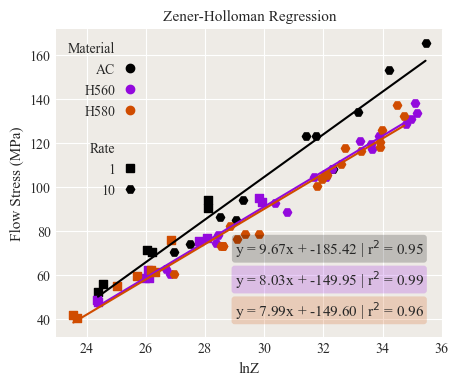

In [16]:
fig, axs = plt.subplots(1, 1, figsize=(5, 4))
mat_cmap = mpl.colors.LinearSegmentedColormap.from_list("", mpl.cm.gnuplot(np.linspace(0, 1, 4))[:4])

pam.plot_ZH_regression(material_analysis_ds, group_by='material', color_by='material', cmap=mat_cmap, marker_by='rate',
                       flow_stress_key='flow_Stress(MPa)', rate_key='rate', temperature_key='flow_temp(K)', ax=axs,
                       eq_hscale=0.1);

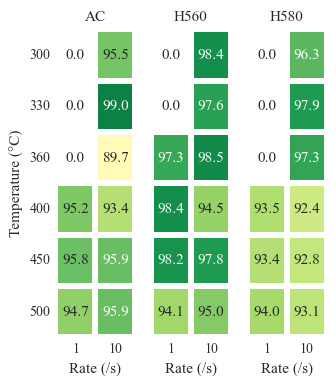

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(3.5, 4))
conformance_matrix(material_analysis_ds, axs);

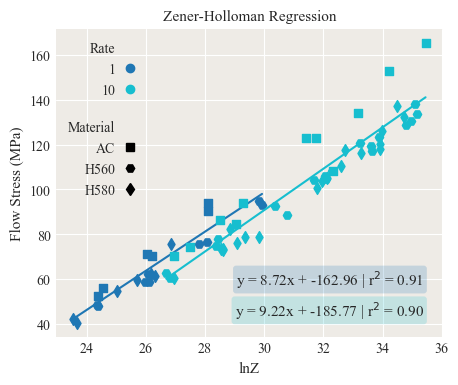

In [18]:
fig, axs = plt.subplots(1, 1, figsize=(5, 4))
ax = pam.plot_ZH_regression(rate_analysis_ds, group_by='rate', color_by='rate', cmap='tab10', marker_by='material',
                            flow_stress_key='flow_Stress(MPa)', rate_key='rate', temperature_key='flow_temp(K)', ax=axs,
                            eq_hscale=0.1)

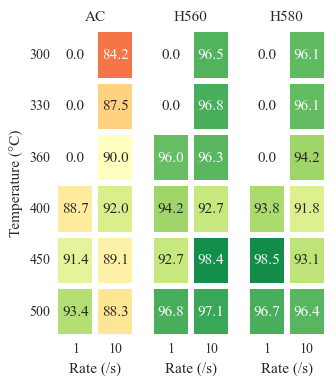

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(3.5, 4))
conformance_matrix(rate_analysis_ds, axs);

### Tables

In [20]:
df = pam.make_representative_info(material_analysis_ds, group_by_keys=['material', 'rate', 'temperature'],
                                  group_info_cols=['lnZ_fit_residual', 'lnZ', 'ZH_parameter', 'flow_TC1(C)',
                                                   'flow_Stress(MPa)'])
table = df[['material', 'rate', 'temperature', 'flow_Stress(MPa)', 'flow_TC1(C)', 'ZH_parameter', 'lnZ']].sort_values(['temperature', 'material'])

In [21]:
table_s1 = table[table['rate'] == 1].drop(columns=['rate'])
for col in ['flow_Stress(MPa)', 'flow_TC1(C)', 'lnZ']:
    table_s1[col] = table_s1[col].apply(lambda x: f'{x:.3g}')
table_s1.style.to_latex('info/s1_table.tex')

In [22]:
table_s10 = table[table['rate'] == 10].drop(columns=['rate'])
for col in ['flow_Stress(MPa)', 'flow_TC1(C)',  'lnZ']:
    table_s10[col] = table_s10[col].apply(lambda x: f'{x:.3g}')
table_s10.style.to_latex('info/s10_table.tex')

## Dan MSc Figures

In [23]:
def ds_subplot2(ds: DataSet, rate, **kwargs):
    return pam.plotting.dataset_subplots(
        ds, shape=(3, 1), xlim=(-0.2, 1.2), figsize=(2.4, 6),
        cols_by='rate', rows_by='material',
        col_vals=[[rate]], row_vals=[['AC'], ['H560'], ['H580']],
        row_titles=['AC', 'H560', 'H580'],
        styler=styler, subplot_legend=False, plot_legend=False,
        **kwargs
    )


def ds_subplot3(ds: DataSet, rate, **kwargs):
    return pam.plotting.dataset_subplots(
        ds, shape=(3, 1), xlim=(-0.2, 1.2), figsize=(2.4, 6),
        cols_by='rate', rows_by='material',
        col_vals=[[rate]], row_vals=[['AC'], ['H560'], ['H580']],
        styler=styler, subplot_legend=False, plot_legend=False,
        **kwargs
    )

### Figure 5.11

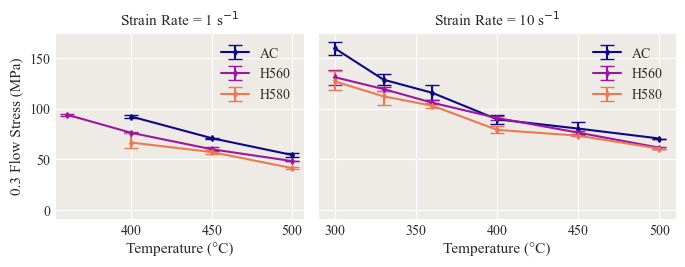

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(8, 2.4), sharey='all', gridspec_kw={'width_ratios': [1, 1.44]})
colors = ([0.05, 0.03, 0.528, 1.0], [0.611, 0.09, 0.62, 1.0], [0.928, 0.473, 0.326, 1.0])

for i, rate in enumerate([1, 10]):
    data = df[df['rate'] == rate].sort_values('temperature')
    for c, material in enumerate(['AC', 'H560', 'H580']):
        mat_data = data[data['material'] == material]
        axs[i].errorbar(mat_data['temperature'], mat_data['flow_Stress(MPa)'],
                        yerr=[mat_data['flow_Stress(MPa)'].values - mat_data['min_flow_Stress(MPa)'].values,
                              mat_data['max_flow_Stress(MPa)'].values - mat_data['flow_Stress(MPa)'].values],
                        label=material, capsize=5, marker='d', markersize=3, color=colors[c])
    axs[i].set(xlabel='Temperature (°C)', ylabel='0.3 Flow Stress (MPa)', title=f'Strain Rate = {rate} s$^{{-1}}$')
    axs[i].axhline(y=0, lw=0)
    axs[i].legend()

axs[1].set_ylabel('')
plt.subplots_adjust(wspace=0.05, hspace=0.05)

### Figure 5.12 

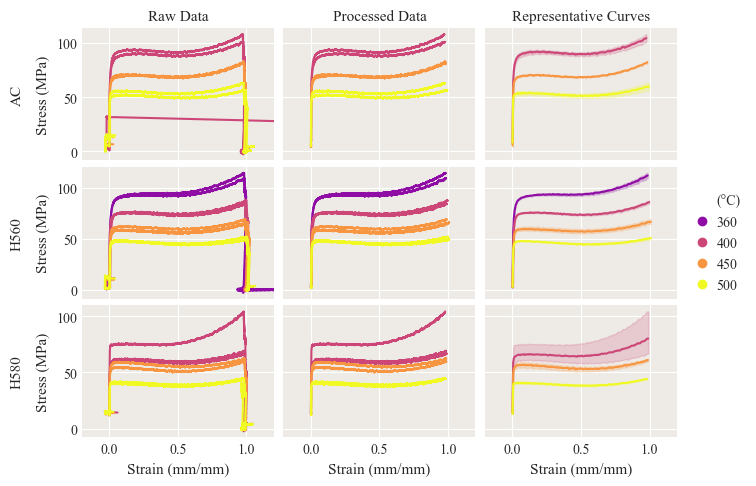

In [25]:
fig, axs = plt.subplots(3, 3, figsize=(7, 5.), sharex='col', sharey='row')

ds_subplot2(raw_ds, 1, axs=axs[:, 0], **stress_strain_labels)
ds_subplot3(processed_ds, 1, axs=axs[:, 1], **stress_strain_labels)
ds_subplot3(repr_ds, 1, axs=axs[:, 2], **stress_strain_labels, fill_between=('min_Stress(MPa)', 'max_Stress(MPa)'))

for ax in axs[:, 1:3].flat:
    ax.set_ylabel('')

for ax, title in zip(axs[0, :].flat, ['Raw Data', 'Processed Data', 'Representative Curves']):
    ax.set_title(title)

handles = styler.legend_handles()
del handles[1:3]

# plt.subplots_adjust(right=0.88)
axs.flat[0].get_figure().legend(handles=handles, loc='center right',
                                bbox_to_anchor=(1.085, 0.5), handletextpad=0.05)

plt.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0.05)

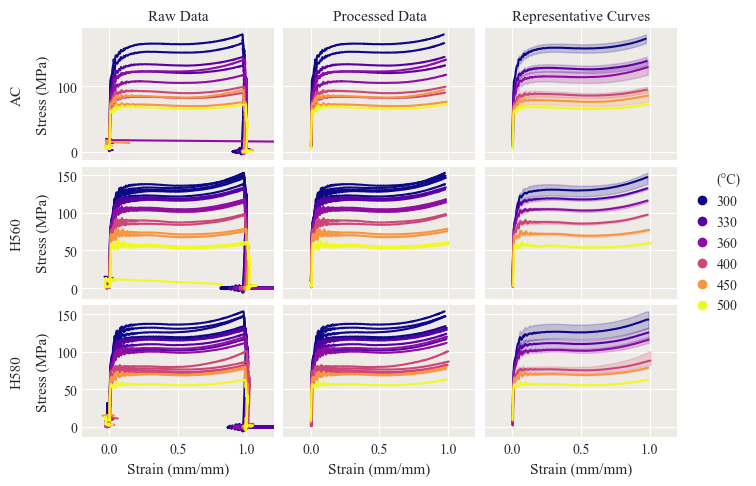

In [26]:
fig, axs = plt.subplots(3, 3, figsize=(7, 5.), sharex='col', sharey='row')

ds_subplot2(raw_ds, 10, axs=axs[:, 0], **stress_strain_labels)
ds_subplot3(processed_ds, 10, axs=axs[:, 1], **stress_strain_labels)
ds_subplot3(repr_ds, 10, axs=axs[:, 2], **stress_strain_labels, fill_between=('min_Stress(MPa)', 'max_Stress(MPa)'))

for ax in axs[:, 1:3].flat:
    ax.set_ylabel('')

for ax, title in zip(axs[0, :].flat, ['Raw Data', 'Processed Data', 'Representative Curves']):
    ax.set_title(title)

handles = styler.legend_handles()

axs.flat[0].get_figure().legend(handles=handles, loc='center right',
                                bbox_to_anchor=(1.085, 0.5), handletextpad=0.05)

plt.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0.05)

### Figure 5.13

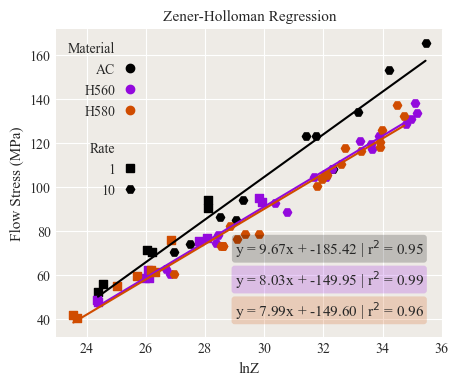

In [27]:
fig, axs = plt.subplots(1, 1, figsize=(5, 4))
mat_cmap = mpl.colors.LinearSegmentedColormap.from_list("", mpl.cm.gnuplot(np.linspace(0, 1, 4))[:4])

pam.plot_ZH_regression(material_analysis_ds, group_by='material', color_by='material', cmap=mat_cmap, marker_by='rate',
                       flow_stress_key='flow_Stress(MPa)', rate_key='rate', temperature_key='flow_temp(K)', ax=axs,
                       eq_hscale=0.1);

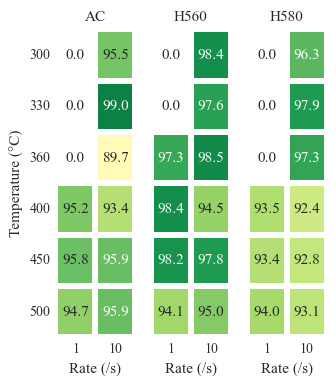

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(3.5, 4))
conformance_matrix(material_analysis_ds, axs);